# XGBoost - WithDask

**Using Optuna for hyper-parameter search  to predict TPSA from Pharmacophores**

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
%load_ext autoreload  
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [2]:
# Models
import os, sys
import numpy as np
import pandas as pd
import numpy as np
import math
import pickle
import itertools
import copy 
import joblib
import scipy.stats as sps 
import matplotlib.pyplot as plt

from collections.abc import Iterator
from datetime import datetime
from pprint import PrettyPrinter

from utils import *
from utils_ml import model_selection
# from multiprocessing import Pool, process

pp = PrettyPrinter(indent=4)
np.set_printoptions(edgeitems=3, infstr='inf', linewidth=150, nanstr='nan')
pd.options.display.width = 170

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


#### xgboost and dask imports 

In [3]:
import joblib
# from dask_cuda import LocalCUDACluster
# from sklearn.model_selection import GridSearchCV
import optuna

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor

import dask
import dask.array as da
import dask.dataframe as dd
from dask import delayed
from dask.distributed import Client
from dask.distributed import LocalCluster
import dask_ml.model_selection as dcv
from dask_ml.model_selection import train_test_split
from dask_ml.model_selection import GridSearchCV, IncrementalSearchCV, HyperbandSearchCV
from dask_ml.metrics import mean_squared_error, r2_score, mean_squared_log_error
import sklearn.metrics as skm

/home/kevin/miniforge3/envs/cp/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


In [4]:
os.environ["WANDB_NOTEBOOK_NAME"] = "Adashare_Train.ipynb"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
# time.strftime(' %x%X')
# datetime.now().strftime('%X.%f')
# time.strftime('%X %x %Z')
print(datetime.now().strftime('%D-%X.%f'))
time_fmt = '%Y-%M-%d %H:%m:%S.%f'
print(datetime.now().strftime(time_fmt))

01/25/24-11:16:40.612945
2024-16-25 11:01:40.613212


In [7]:
import logging
logLevel = os.environ.get('LOG_LEVEL', 'INFO').upper()
FORMAT = '%(asctime)s - %(levelname)s: - %(message)s'
logging.basicConfig(level="INFO", format= FORMAT)
logging.getLogger("imported_module").setLevel(logging.CRITICAL)
logging.info(f" 1/7- engine connected")
logging.warning(f" 1/7- engine connected")
logging.error(f" 1/7- engine connected")
logging.critical(f" 1/7- engine connected")

2024-01-25 11:16:43,571 - INFO: -  1/7- engine connected
2024-01-25 11:16:43,572 - WARNING: -  1/7- engine connected
2024-01-25 11:16:43,573 - ERROR: -  1/7- engine connected
2024-01-25 11:16:43,574 - CRITICAL: -  1/7- engine connected


In [8]:
print(logging.NOTSET, logging.DEBUG,  logging.INFO, logging.WARN, logging.WARNING, logging.ERROR, logging.CRITICAL,  logging.FATAL)
xgb.__version__

0 10 20 30 30 40 50 50


'2.0.3'

#### Datasets

In [9]:
prefix = '' ### Target-2' , 'MOA'
input_path ="./input/"
output_path ="./output_11102023/"
prefix_lc = prefix.lower().replace('-', '_')

CompoundExtendedMetadata2SampleFile = f"{output_path}{prefix_lc}compound_extended_metadata_2samples.csv"
CompoundProfiles2SampleFileCSV      = f"{output_path}{prefix_lc}compound_profiles_2samples.csv"
CompoundExtendedMetadataSampleFile  = f"{output_path}{prefix_lc}compound_extended_metadata_samples.csv"
featureSelectionFile                = f"./metadata/feature_selection_columns.pkl"
trainingMetrics                     = f"{output_path}{prefix_lc}training_metrics.pkl"
print()
print(f" Compound Extended Metadata 2 SampleFile  : {CompoundExtendedMetadata2SampleFile }")
print(f" Compound Profiles 2 Samples File CSV     : {CompoundProfiles2SampleFileCSV}")
print(f" ")
print(f" featureSelectionFile                     : {featureSelectionFile}")
print(f" training metrics                         : {trainingMetrics}")


 Compound Extended Metadata 2 SampleFile  : ./output_11102023/compound_extended_metadata_2samples.csv
 Compound Profiles 2 Samples File CSV     : ./output_11102023/compound_profiles_2samples.csv
 
 featureSelectionFile                     : ./metadata/feature_selection_columns.pkl
 training metrics                         : ./output_11102023/training_metrics.pkl


#### Helper functions

In [10]:
def result_model_selection(results, name):
    df_results = pd.DataFrame({'model'     : [name] * len(results.cv_results_['params']),
                               'params'    : results.cv_results_['params'],
                               'mean score': results.cv_results_['mean_test_score'],
                               'std score' : results.cv_results_['std_test_score'],
                               'rank'      : results.cv_results_['rank_test_score']
                              })
    return df_results

In [11]:
def split_Xy(input, y_col = ["Metadata_log10TPSA"] ):
    if not isinstance(y_col,list):
        y_col = list(y_col)
    y_output = input[y_col]
    X_output = input.drop(columns=y_col)        
    return X_output, y_output

In [12]:
def make_cv_splits(df_profiles, n_folds: int = 5,) -> Iterator[tuple[dd.DataFrame, dd.DataFrame]]:
    frac = [1 / n_folds] * n_folds
    # print(frac, n_folds)
    splits = df_profiles.random_split(frac, shuffle=True)
    # print(type(splits[i]))
    # print(f"splits: {type(splits)} ")
    
    for i in range(n_folds):
        print(f"Training/Test split #{i}")
        train = [splits[j] for j in range(n_folds) if j != i]
        train = dd.concat(train)
        test = splits[i] 
        X_train, y_train = split_Xy(train, y_columns)
        X_test , y_test  = split_Xy(test, y_columns)
        yield (X_train, y_train), (X_test, y_test)
        # yield train, test

In [13]:
def read_cell_profiles_old(profile_file, rows = None, skiprows = None):
    print(f" Reading cell profiles file :  {profile_file}")
    df_ps = dd.read_csv(profile_file, usecols=Xy_columns, dtype= Xy_columns_dtype)   
    print(f" Number of partitions:  {df_ps.npartitions}   partition(1) shape: {df_ps.get_partition(0).shape}")
    
    if skiprows is not None:
        print(f" skipping {skiprows} rows")
        df_ps = df_ps[skiprows:]
        
    if rows is not None:
        print(f" limiting output to {rows} rows")
        df_ps = df_ps.head(npartitions = df_ps.npartitions, n=rows)        
        df_ps = dd.from_pandas(df_ps, npartitions = 100)       
        rows_str = f"{rows}"
    else:
        rows_str = "ALL"
    print()    
    print(f" Reading {rows_str} rows into {type(df_ps)} shape: {df_ps.shape }")
    print(f" Number of partitions:  {df_ps.npartitions}   partition(1) shape: {df_ps.get_partition(0).compute().shape}")    
    return df_ps

In [14]:
def read_cell_profiles(profile_file, rows = None):
    print(f" Reading cell profiles file :  {profile_file}")
    df_ps = dd.read_csv(profile_file, usecols=Xy_columns, dtype= Xy_columns_dtype)   
    print(f" Number of partitions:  {df_ps.npartitions}   partition(1) shape: {df_ps.get_partition(0).shape}")
    
    # if skiprows is not None:
    #     print(f" Skipping {skiprows} rows")
    #     df_ps = df_ps.loc[skiprows:]
        
    if rows is not None:
        print(f" Limiting output to {rows} rows")
        df_ps = df_ps.head(npartitions = df_ps.npartitions, n=rows)        
        df_ps = dd.from_pandas(df_ps, npartitions = 100)       
        rows_str = f"{rows}"
    else:
        rows_str = "ALL"
    
    print()    
    print(f" Reading {rows} rows into {type(df_ps)} shape: {df_ps.shape }")
    print(f" Number of partitions:  {df_ps.npartitions}   " )
    return df_ps

In [15]:
def get_dd_subset(df_ps, skiprows = 0, nrows=10, ss = None, verbose = False):
    if ss is None: 
        ss = df_ps.map_partitions(len).compute()
    ss_cumsum = ss.cumsum()
    ss_floorsum = ss.cumsum() - ss
    last_partition = ss_cumsum.index[-1]  
    _start_row = skiprows
    _end_row   = _start_row + nrows 

    if verbose:
        print(f" Skip {skiprows} rows then read {nrows} rows : from  row# {_start_row} to {_end_row}")
    assert skiprows < ss_cumsum[last_partition], f"Row skip ({skiprows}) is equal or larger than dataframe ({ss_cumsum[last_partition]})" 
    
    _start_row = _start_row if skiprows >0 else -1 
    st_idx = ss_floorsum[ss_floorsum.gt(_start_row)].index
    if verbose:
        print(f" st idx : {st_idx}")
 
    if len(st_idx) == 0 :
        print(f" No partitions satisfy skiprows = {skiprows}. Last partition begins at row {ss_floorsum.tail(1).item()}")
        return -1,-1
     
    st = st_idx.min() if len(st_idx) > 0 else 0       
    counter = 0
    en = st
 
    while counter < nrows  and en <= last_partition:
        counter += ss[en]
        print(f" Partition {en} (starting row: {ss_floorsum[en]}   ending row: {ss_cumsum[en]})  rows: {ss[en]}   count: {counter}")
        en +=1
    
    if verbose:
        print()
        print(f" Partition range: [{st}   {en}] ---- total rows included {ss[st:en].sum()}")
 
    en = en + 1 if en == st else en
    
    if verbose:
        print(f" ***** output (st,en) is ({st} , {en})")
        for i in range(st, en):
            print(f" {ss_floorsum[i]}   {ss_cumsum[i]}")
        print("\n\n")
    return st, en 

In [16]:
# xgb_grid_parameters = {
# 'learning_rate': [0.1, 0.01],                  # 'max_depth': [12, 10 ,8],                           # 'max_depth': [15,10,5],   # 'min_child_weight':[5,3,2,1],    # 'gamma':[1, 2.5, 3, 3.5, 4, 5, 10],  
# 'subsample':    [i/10.0 for i in range(6,11)], # 'colsample_bytree': [i/10.0 for i in range(5,11)],  # 'colsample_bytree':[0.5], # 'n_estimators': [1250, 1000, 750, 500, 200]}
# xgb_reg.set_params(**xgb_grid_parameters)

def propose_parameters(trial):
    _params = {

        "verbosity"          : 0,
        "objective"          :  "reg:squarederror",
        "eval_metric"        :  "rmse",
        "booster"            :  "gbtree",   ## trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        
        # "n_estimators"     : trial.suggest_int("n_estimators", 75, 125),
        "tree_method"        : "auto",
        
        ## eta/learning_rate default =0.3 Step size shrinkage used in update to prevents overfitting. 
        ## After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.
        "learning_rate"    : trial.suggest_float("learning_rate", 0.01, 10, log=True, step = None),

        
        ## GAMMA / min_split_loss: Default=0. Minimum loss reduction required to make a further partition on a leaf node of the tree. 
        ##                    The larger gamma is, the more conservative the algorithm will be.
        ##                    range: [0, Inf) 
        "min_split_loss"   : trial.suggest_float("min_split_loss", 0, 10),

        ## min_child_weight:  [default=1] Minimum sum of instance weight (hessian) needed in a child. 
        ##                    If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, 
        ##                    then the building process will give up further partitioning. In linear regression task, this simply corresponds
        ##                    to minimum number of instances needed to be in each node. 
        ##                    The larger min_child_weight is, the more conservative the algorithm will be.
        ##                    range: [0,∞]        
        "min_child_weight"   : trial.suggest_float("min_child_weight", 0, 10),

        ## max_delta_step:    [default=0] Maximum delta step we allow each leaf output to be. 
        ##                    If the value is set to 0, it means there is no constraint. If it is set to a positive value, it can help making 
        ##                    the update step more conservative. Usually this parameter is not needed, but it might help in logistic regression 
        ##                    when class is extremely imbalanced. Set it to value of 1-10 might help control the update.
        ##                    range: [0,∞]        
        "max_delta_step"   : trial.suggest_float("max_delta_step", 0, 10),

        ## subsample [default=1]: Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half
        ##                       of the training data prior to growing trees. and this will prevent overfitting. Subsampling will occur once 
        ##                      in every boosting iteration.
        ##                      range: (0,1]
        "subsample"         : trial.suggest_float("subsample", 0.4, 1.0),

        ## sampling_method:  [default= uniform] The method to use to sample the training instances.
        ##                   uniform: each training instance has an equal probability of being selected. Typically set subsample >= 0.5 for good results.
        ##                   gradient_based: the selection probability for each training instance is proportional to the regularized absolute value of gradients 
        ##                   (more specifically, SQRT(g^2 + lambda*h^2). subsample may be set to as low as 0.1 without loss of model accuracy. 
        ##                   Note that this sampling method is only supported when tree_method is set to hist and the device is cuda; 
        ##                   other tree methods only support uniform sampling.        

        
        ## All colsample_by* parameters have a range of (0, 1], the default value of 1
        ## and specify the fraction of columns to be subsampled.
        
        ## colsample_bytree;  [default=1] is the subsample ratio of columns when constructing each tree. 
        ##                    Subsampling occurs once for every tree constructed.
        "colsample_bytree" : 1.0, ## trial.suggest_float("colsample_bytree", 0.5, 1),

        ## colsample_bylevel: [default=1] is the subsample ratio of columns for each level. Subsampling occurs once for every new depth level reached in a tree. 
        ##                    Columns are subsampled from the set of columns chosen for the current tree.
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1),
        
        ## colsample_bynode:  [default=1] the subsample ratio of columns for each node (split). Subsampling occurs once every time a new split is evaluated. 
        ##                    Columns are subsampled from the set of columns chosen for the current level.
        "colsample_bynode" : trial.suggest_float("colsample_bynode", 0.5, 1),

        # lambda [default=1, alias: reg_lambda]
        # L2 regularization term on weights. Increasing this value will make model more conservative.
        # range: [0, ∞]

        # alpha [default=0, alias: reg_alpha]
        # L1 regularization term on weights. Increasing this value will make model more conservative.        
        # range: [0, ∞]

        # tree_method string [default= auto] The tree construction algorithm used in XGBoost. See description in the reference paper and Tree Methods.
        #         Choices: auto, exact, approx, hist, this is a combination of commonly used updaters. 
        #                  For other updaters like refresh, set the parameter updater directly.
        #                  auto:   Same as the hist tree method.
        #                  exact:  Exact greedy algorithm. Enumerates all split candidates`.
        #                  approx: Approximate greedy algorithm using quantile sketch and gradient histogram.
        #                  hist:   Faster histogram optimized approximate greedy algorithm.   

        ## scale_pos_weight [default=1] Control the balance of positive and negative weights, useful for unbalanced classes. 
        ##                 A typical value to consider: sum(negative instances) / sum(positive instances)        

        ## grow_policy [default= depthwise]
        
        ## max_leaves [default=0] Maximum number of nodes to be added. Not used by exact tree method.
        # "max_leaves"       : trial.suggest_int("max_leaves", 0, 2),
        "max_leaves"       : 0, 
        
        ## max_bin, [default=256]

        ## num_parallel_tree, [default=1]
        
        ## max_depth:  [Default=6] Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. 
        ##             0 indicates no limit on depth. Beware that XGBoost aggressively consumes memory when training a deep tree. 
        ##             exact tree method requires non-zero value. 
        "max_depth"        : trial.suggest_int("max_depth", 1, 15),

        ## SET STATIC ###############################################################################
        
        ## lambda [default=1, alias: reg_lambda]  L2 regularization term on weights. Increasing this value will make model more conservative.
        ##                    range: [0, Inf) 
        # "reg_lambda"       : trial.suggest_float("reg_lambda", 0, 10),
        "reg_lambda"       : 3.2267,   
        

        # "max_cat_to_onehot": trial.suggest_int("max_cat_to_onehot", 1, 10),
    }    
    return _params

In [17]:
def disp_trial_info(trial):
    print(f"Best trial:  {trial.number}   {trial.state} ")
    print(f" start: {trial.datetime_start} , end:  {trial.datetime_complete}  duration: {trial.duration}")

    print(f" Intermediate values: {trial.intermediate_values}")
    print(f" Trial last step    : {trial.last_step} ")
    for dist in trial.distributions:
        print(f"    {dist:30s}   {trial.distributions[dist]}   ")
    print()
    print(" Parameters: ")
    print("-------------")
    for key in trial.params:
        print(f"    {key:30s} {trial.params[key]:.7f}    {trial.distributions.get(key, 'n/a')}     ")
    print()
    print(f" Trial results: {trial.values}")
  
# print("  Number of estimators: {}".format(trial.user_attrs["n_estimators"]))

#### Create dask cluster and client 

In [18]:
try:
    cluster.close()
    del cluster
except Exception as e:
    print("Cluster close failed")


Cluster close failed


In [19]:
n_workers = 6
n_threads = 2
cluster = LocalCluster("Kevins_Cluster", n_workers=n_workers, threads_per_worker= n_threads, silence_logs = logging.WARNING)
# cluster = LocalCluster("Kevins_Cluster", n_workers=2, threads_per_worker=2)
# cluster = LocalCluster()

In [20]:
print(cluster)
cluster.dashboard_link
# cluster.worker_spec
# cluster
# cluster.workers[0].status
# cluster.scale(5)
# cluster.close()
# del cluster

Kevins_Cluster(Kevins_Cluster, 'tcp://127.0.0.1:34463', workers=6, threads=12, memory=64.00 GiB)


'http://127.0.0.1:8787/status'

In [21]:
try:
    client.close()
    del client
except Exception as e:
    print("Client close failed")
else:
    print("Client close succeeded")

Client close failed


In [22]:
client = Client(cluster)
client.status
client

# client = Client(cluster.scheduler_address)
# client = Client("tcp://127.0.0.1:37937")
# client = Client(processes = False)
# client = Client("tcp://127.0.0.1:37937")
# client = Client(processes = False)
# client = Client(cluster.scheduler_address)

# client.start
# client.status
# client.close()
# client.status
# del client


'running'

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 6
Total threads: 12,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34463,Workers: 6
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:32827,Total threads: 2
Dashboard: http://127.0.0.1:37281/status,Memory: 10.67 GiB
Nanny: tcp://127.0.0.1:40571,


In [23]:
# with open("./metadata/parquet_columns.pkl",'rb') as f:
#     ParquetColumns = pickle.load(f)

# for k,v in ParquetColumns.items():
#     print(f" {k:20s}   items: {len(v)}")

# type(ParquetColumns['Cells']['Cells_AreaShape_Area'])
# ParquetColumns['Cells']
# del ParquetColumns

# df_X = dd.read_csv(profilesFile, blocksize="100MB", usecols=X_columns, dtype= x_columns_dtype)  ##, index_col = 'CASRN')
# df_y = dd.read_csv(profilesFile, blocksize="100MB", usecols=y_columns, dtype=y_columns_dtype)  ##, index_col = 'CASRN')

# df_X_array = df_X_array.rechunk(chunks=(10000,-1))         # df_y_array = df_y.to_dask_array(lengths = True)
# df_X_array.to_zarr('df_X_array.zarr' )                     # df_y_array.to_zarr('df_y_array.zarr' ) 
# df_X_array.to_hdf5('df_X_array.hdf5' , '/x')               # df_y_array.to_hdf5('df_y_array.hdf5' , '/x')  
# df_X_array = dask.array.from_zarr('df_X_array.zarr' )      # df_y_array = dask.array.from_zarr('df_y_array.zarr' )

# df_y = df_profiles[y_columns].compute()
# df_X = df_profiles[list(x['selected'])] ## .drop(labels=x_columns_drop, axis =1)


# def read_profiles(n_rows = 50000):
#     return    pd.read_csv(CompoundProfiles2SampleFileCSV, usecols=all_columns, dtype= all_columns_dtype, nrows = 50000)     

# read_profiles = delayed(read_profiles)
# read_profiles

### Read Features metadata file

In [24]:
print(f" Features select file:  {featureSelectionFile}")

with open(featureSelectionFile, 'rb') as f: 
    x = pickle.load(f)
    
for i in x:
    print(f" {i:20s}    {len(x[i])} ")

metadata_columns = set(["Metadata_Source", "Metadata_Batch", "Metadata_Plate", "Metadata_Well", "Metadata_JCP2022"])
metadata_columns_dtype = {x: pd.StringDtype()  for x in metadata_columns} 

label_columns =  set(["Metadata_TPSA", "Metadata_lnTPSA", "Metadata_log10TPSA"])
label_columns_dtype = {x: np.dtype('float32') for x in label_columns}

X_columns = x['selected']
X_columns_dtype = {x: np.dtype('float32') for x in X_columns}

y_columns = set(["Metadata_log10TPSA"])
y_columns_dtype = {x: np.dtype('float32') for x in y_columns} ## "Metadata_log10TPSA":np.dtype('float64')}

Xy_columns = y_columns | X_columns
Xy_columns_dtype = y_columns_dtype | X_columns_dtype

all_columns = metadata_columns | label_columns | X_columns
all_columns_dtype = metadata_columns_dtype | label_columns_dtype | X_columns_dtype


print(f" len(metadata_columms)        : {len(metadata_columns)} ")
print(f" len(metadata_columms_dtype)  : {len(metadata_columns_dtype)} ")
print(f" len(label_columms)           : {len(label_columns)} ")
print(f" len(label_columms_dtype)     : {len(label_columns_dtype)} ")
print(f" len(X_columms)               : {len(X_columns)}")
print(f" len(X_columms_dtype)         : {len(X_columns_dtype)}")
print(f" len(y_columms)               : {len(y_columns)}")
print(f" len(y_columms_dtype)         : {len(y_columns_dtype)}")
print(f" len(Xy_columms)              : {len(Xy_columns)}")
print(f" len(Xy_columms_dtype)        : {len(Xy_columns_dtype)}")
print(f" len(all_columms)             : {len(all_columns)} ")
print(f" len(all_columms_dtype)       : {len(all_columns_dtype)} ")

# for k  in sorted(all_columns_dtype.keys()):
#     print(f" {k:60s}  {all_columns_dtype[k]}")

 Features select file:  ./metadata/feature_selection_columns.pkl
 selected                1477 
 dropped_correlation     2193 
 dropped_variance        0 
 len(metadata_columms)        : 5 
 len(metadata_columms_dtype)  : 5 
 len(label_columms)           : 3 
 len(label_columms_dtype)     : 3 
 len(X_columms)               : 1477
 len(X_columms_dtype)         : 1477
 len(y_columms)               : 1
 len(y_columms_dtype)         : 1
 len(Xy_columms)              : 1478
 len(Xy_columms_dtype)        : 1478
 len(all_columms)             : 1485 
 len(all_columms_dtype)       : 1485 


# XGBoost + Dask - Development 

- Need to convert Dask data frames to dask arrays in order to use data in parm grid search

### Read compound profiles

In [ ]:
# del df_profiles
df_profiles = read_cell_profiles(CompoundProfiles2SampleFileCSV, rows = 100000, skiprows = None)

type(df_profiles)
df_profiles.head(3)
df_profiles.shape

In [ ]:
# df_X_array = df_X_array.rechunk(chunks=(10000,-1))
# df_y_array = df_y_array.rechunk(chunks=(10000,-1))
# df_X_array.chunks
# df_y_array.chunks
# df_y_array.shape

# train_X, test_X,  train_y, test_y = train_test_split(df_X_array, df_y_array, 
#                                                      train_size= 0.8, 
#                                                      test_size=0.2, 
#                                                      random_state= 1234, 
#                                                      shuffle=True)
#
# print(f" Training data         : {train_X.shape} \t training labels: {train_y.shape}")
# print(f" Test & Validation data: {test_X.shape}  \t test labels    : {test_y.shape}")

# val_X ,  test_X,  val_y  , test_y = train_test_split(test_X, test_y, 
#                                                      train_size= 0.5, 
#                                                      test_size=0.5, 
#                                                      random_state= 1234, 
#                                                      shuffle=True)
# print()
# print(f" Training data   : {train_X.shape} \t Training labels: {train_y.shape}")
# print(f" Validation data : {test_X.shape} \t Val labels     : {test_y.shape}")
# print(f" Test set data   : {test_X.shape} \t Test labels    : {test_y.shape}")

In [ ]:
study_params = {  'learning_rate': 0.255, 'max_depth': 4, 'max_leaves': 10} 
mse_scores = []
R2_scores = []
print(study_params)
iter_files = make_cv_splits()

### Beginning of loop

In [ ]:
(X_train,y_train), (X_test, y_test) = next(iter_files)

In [ ]:
logging.info(f"Building TRAINING DMatrix...")
d_train = xgb.dask.DaskDMatrix(client, X_train, y_train )
logging.info(f"Building TRAINING DMatrix...Completed")

In [ ]:
logging.info(f"Building TEST DMatrix...")
d_test = xgb.dask.DaskDMatrix(client, X_test, y_test )
logging.info(f"Building TEST DMatrix...Completed")

In [ ]:
xgb.__version__
xgb.config_context(device = "gpu", booster = "gbtree", verbosity = 0, validate_parameters = True ) 
xgb.get_config()['verbosity']
xgb.set_config(use_rmm = True, verbosity = 1)
xgb.set_config()
xgb.get_config()

In [ ]:
X_train.shape
y_train.shape

X_test.shape
y_test.shape

In [ ]:
logging.info(f"Training model...")
model = xgb.dask.train(
    None,
    {"verbosity": 0, "tree_method": "hist", **study_params},
    d_train,
    num_boost_round=100,
    evals=[(d_train, "train"), (d_test, "test")],
    verbose_eval=False
)
logging.info(f"Training model...Completed")

In [ ]:
logging.info(f"Running model on test data...")
predictions = xgb.dask.predict(client, model,d_test).compute()
logging.info(f"Running model on test data...Completed")

In [ ]:
logging.info(f"Reshape y_test data...")
# y_test_c = y_test.to_dask_array(lengths=True)
y_test_c = y_test.compute().to_numpy().squeeze()
logging.info(f"Reshape y_test data...Complete")

In [ ]:
print(f" y_test     : {type(y_test)} \t shape: {y_test.shape}") 
print(f" y_test_c   : {type(y_test_c)} \t\t\t shape: {y_test_c.shape}")
print(f" Predictions: {type(predictions)} \t\t\t shape: {predictions.shape}")

In [ ]:
logging.info(f"Calculating R2 and MSE metrics...")
R2_score = skm.r2_score(
    y_true = y_test_c,
    y_pred = predictions,
)

mse_score = skm.mean_squared_error(
    y_true = y_test_c,
    y_pred = predictions,
    squared=True,
)
logging.info(f"Calculating R2 and MSE metrics...Completed")

In [ ]:
logging.info(f"Measuring accuracy of model vs. ground truth...")
mse_score = mean_squared_error(
    y_true = y_test_c,
    y_pred = predictions,
    squared=True,
    # compute=True,
)
 
R2_score = r2_score(
    # y_true = d_test.get_label(),
    # y_true = y_test.to_dask_array(),
    y_true = y_test_c,
    y_pred = predictions,
    compute=True,
)
logging.info(f"Measuring accuracy of model vs. ground truth...Completed")

In [ ]:
# print(score.shape, type(score))
print(y_test_c)
print(predictions)
print("mse_score: " , mse_score)
print("R2_score : " , R2_score)


mse_scores
R2_scores

In [ ]:
del d_train, d_test
del X_train, y_train, X_test, y_test, y_test_c,
del model, predictions, mse_score, R2_score

### End of loop

In [ ]:
# for x in mse_scores:
#     print(x.compute())
mse_scores_np = np.array(mse_scores, dtype =np.float64)
mse_scores_np
R2_scores_np = np.array(R2_scores, dtype =np.float64)
R2_scores_np

In [ ]:
print(f"RSME : {mse_scores_np.mean():.5f} +/- {mse_scores_np.std():.5f}")
# return mse_scores.mean()
print("-" * 80)
print(f"R^2  : {R2_scores_np.mean():.5f} +/- {R2_scores_np.std():.5f}")
# return mse_scores.mean()


In [ ]:
# type(model)
data = { 'mse_scores' : mse_scores_np,
         'R2_scores' : R2_scores_np}
    
with open(trainingMetrics, 'wb') as f: 
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
with open(trainingMetrics, 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    data = pickle.load(f)
data

# XGBoost - Using Optuna for hyper-parameter search

## Setup ML env

In [25]:
# del df_profiles
df_profiles = read_cell_profiles(CompoundProfiles2SampleFileCSV, rows = 200000)
# type(df_profiles)
# df_profiles.head(3)
# df_profiles.columns

 Reading cell profiles file :  ./output_11102023/compound_profiles_2samples.csv
 Number of partitions:  261   partition(1) shape: (Delayed('int-f6fdacbd-a5ad-4134-98ef-7ee270eddae4'), 1478)
 Limiting output to 200000 rows


/home/kevin/miniforge3/envs/cp/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(
/home/kevin/miniforge3/envs/cp/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(
/home/kevin/miniforge3/envs/cp/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(
/home/kevin/miniforge3/envs/cp/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(
/home/kevin/miniforge3/envs/cp/lib/pytho


 Reading 200000 rows into <class 'dask.dataframe.core.DataFrame'> shape: (Delayed('int-e174aa8d-e50e-4f6c-84a1-7f601ec24207'), 1478)
 Number of partitions:  100   


In [26]:
def train_model(iter_files, save = False, **study_params):
    mse_scores = []
    R2_scores = []
    pearson_scores = []
    pearson_ps = []
    model_params = {"verbosity":0, "tree_method": "hist", **study_params}
    
    my_model = None
    
    # for i, (train, test) in enumerate(make_cv_splits()):
    for i, ((X_train,y_train), (X_test, y_test)) in enumerate(iter_files):

        logging.info(f"Building training & test+ DMatrix...")
        d_train = xgb.dask.DaskDMatrix( client, X_train, y_train)      

        # logging.info(f"Building test DMatrix...")
        d_test = xgb.dask.DaskDMatrix(client, X_test, y_test)
        
        booster_model = my_model['booster'] if my_model is not None else None
        logging.info(f"Training model...")
        my_model = xgb.dask.train(
            None,  model_params, d_train,
            xgb_model = booster_model,
            num_boost_round=50,
            evals=[(d_train, "train"), (d_test, "test")],
            verbose_eval=False
        )
        # logging.info(f"Training model...Completed")
        
        logging.info(f"Running model on test data...")
        predictions = xgb.dask.predict(client, my_model, d_test).compute()
        
        # logging.info(f"Reshape y_test data...")
        # y_test_c = y_test.to_dask_array(lengths=True).compute().squeeze()
        y_test_c = y_test.compute().to_numpy().squeeze()

        # print(f" y_test_c: {type(y_test_c)}   Shape:  {y_test_c.shape}       Predictions: {type(predictions)}  shape: {predictions.shape}")
        
        logging.info(f"Compute R2 & MSE scores...")
        R2_score = skm.r2_score(
            y_true = y_test_c,
            y_pred = predictions,
            # compute=True,
        )
        
        mse_score = skm.mean_squared_error(
            y_true = y_test_c,
            y_pred = predictions,
            squared=False,
            # compute=True,
        )

        pearson_corr, pearson_p = sps.pearsonr(y_test_c, predictions)
        # logging.info(f"Compute R2 & MSE scores...Completed")
 
        print(f"MSE Score : {mse_score:.6f}")
        print(f" R2 Score : {R2_score:.6f}")
        print(f"  Pearson : {pearson_corr:.6f}      P: {pearson_p:.6e}")
        
        mse_scores.append(mse_score)
        R2_scores.append(R2_score)
        pearson_scores.append(pearson_corr)
        pearson_ps.append(pearson_p)
        
        # Compute predictions and mean squared error for this iteration
        # while we start the next one
        # scores.append(score.reshape(1).persist())  <--- rsults in errors

        del d_train, d_test, X_train, y_train, X_test, y_test, y_test_c, predictions, mse_score, R2_score        
        print("-" * 80)

    # scores = da.concatenate(scores).compute()
    # print(f"RSME={scores.mean()} +/- {scores.std()}")
    mse_scores_np = np.array(mse_scores, dtype =np.float64)
    R2_scores_np = np.array(R2_scores, dtype =np.float64)
    pearson_scores_np = np.array(R2_scores, dtype =np.float64)
    mse_scores_np
    R2_scores_np    
    pearson_scores_np
    
    print("-" * 80)
    print(f"RSME     : Min: {mse_scores_np.min():.5f}   mean: {mse_scores_np.mean():.5f} +/- {mse_scores_np.std():.5f}")
    print(f"R^2      : Min: {R2_scores_np.min():.5f}    mean: {R2_scores_np.mean():.5f} +/- {R2_scores_np.std():.5f}")
    print(f"Pearson  : Min: {pearson_scores_np.min():.5f}    mean: {pearson_scores_np.mean():.5f} +/- {pearson_scores_np.std():.5f}")
    print("-" * 80)
    print(my_model['history']['test'])
    print(my_model['booster'])
    
    # Only available when early stopping is used 
    # print(my_model['booster'].best_score)
    # print(my_model['booster'].best_iteration)
    
    return my_model, mse_scores_np.mean(), pearson_scores_np.mean()


In [27]:
def objective(trial, disp_params = False, save = True):
    iter_files = make_cv_splits(df_profiles)
    params = propose_parameters(trial)   
    print(f" Training model (trial #{trial.number}) ")
    if disp_params:
        print(f" Parameters:")
        for k, v in params.items():
            print(f"  {k:30s} {v}")
    model, mse_score, pearson_score =  train_model(iter_files, **params)
    if save:
        save_as_filename = f".\saved_models\{study.study_name}_trial_{trial.number:03d}.json"
        print(f" Save model to : {save_as_filename}")
        model['booster'].save_model(save_as_filename)
    return mse_score, pearson_score
    # return params

### Load study

In [28]:
study_name="multiobjective-study-3"

In [29]:
# try:
#     optuna.delete_study(storage="sqlite:///example.db", study_name=study_name)
#     print("delete successful")
# except Exception as e:
#     print("delete failed")

In [30]:
start = datetime.now()
study = optuna.create_study(storage="sqlite:///example.db",
                            study_name="multiobjective-study-3",
                            directions=["minimize", "maximize"], 
                            load_if_exists=True)
# study.set_metric_names(["mse_score", "R2_score"])
print(f"Total time:  {datetime.now() - start}")

[I 2024-01-25 12:07:46,864] Using an existing study with name 'multiobjective-study-3' instead of creating a new one.


Total time:  0:00:00.208571


In [32]:
for st in study.trials:
    print(f"Trial #: {st.number:<4d} {st.state:2d}  ", end="")
    if st.state != 3:
        print(f" {st.values[0]:12.5f}   {st.values[1]:12.5f}")
    else:
        print("\n")
print(" end of trials ")

Trial #: 0     1        0.17054        0.00354
Trial #: 1     1        0.16833        0.02912
Trial #: 2     1        4.70470     -778.38355
Trial #: 3     1        0.17064        0.00240
Trial #: 4     1        0.17041        0.00515
Trial #: 5     1       38.76890   -51495.15402
Trial #: 6     1        0.17075        0.00113
Trial #: 7     1        0.17073        0.00129
Trial #: 8     3  

Trial #: 9     1        0.17074        0.00124
Trial #: 10    1       15.77350    -8695.22164
Trial #: 11    1        9.32062    -2975.71750
Trial #: 12    1        0.17026        0.00688
Trial #: 13    1       22.27700   -17001.89049
Trial #: 14    1       25.41578   -22877.22808
Trial #: 15    1        0.17085       -0.00005
Trial #: 16    1        0.17069        0.00185
Trial #: 17    3  

 end of trials 


### Run studies

In [33]:
start = datetime.now()

study.optimize(objective, n_trials=25, timeout=3600*8, gc_after_trial=True, show_progress_bar=True)

print(f"Total time:  {datetime.now() - start}")

  0%|          | 0/25 [00:00<?, ?it/s]

 Training model (trial #18) 
Training/Test split #0


2024-01-25 12:08:51,606 - INFO: - Building training & test+ DMatrix...
2024-01-25 12:11:04,931 - INFO: - Training model...
2024-01-25 12:11:04,981 - INFO: - start listen on 10.91.28.16:46483
[12:11:05] task [xgboost.dask-0]:tcp://127.0.0.1:32827 got new rank 0
[12:11:05] task [xgboost.dask-1]:tcp://127.0.0.1:39069 got new rank 1
[12:11:05] task [xgboost.dask-2]:tcp://127.0.0.1:39653 got new rank 2
[12:11:05] task [xgboost.dask-3]:tcp://127.0.0.1:44203 got new rank 3
[12:11:05] task [xgboost.dask-4]:tcp://127.0.0.1:37877 got new rank 4
[12:11:05] task [xgboost.dask-5]:tcp://127.0.0.1:37333 got new rank 5
2024-01-25 12:11:05,591 - INFO: - @tracker All of 6 nodes getting started
2024-01-25 12:11:42,645 - INFO: - @tracker All nodes finishes job
2024-01-25 12:11:42,793 - INFO: - Running model on test data...
2024-01-25 12:12:16,273 - INFO: - Compute R2 & MSE scores...


MSE Score : 0.171955
 R2 Score : 0.000301
  Pearson : 0.050538      P: 5.092376e-24
--------------------------------------------------------------------------------
Training/Test split #1


2024-01-25 12:12:19,633 - INFO: - Building training & test+ DMatrix...
2024-01-25 12:14:33,496 - INFO: - Training model...
2024-01-25 12:14:33,508 - INFO: - start listen on 10.91.28.16:37395
[12:14:33] task [xgboost.dask-0]:tcp://127.0.0.1:32827 got new rank 0
[12:14:33] task [xgboost.dask-1]:tcp://127.0.0.1:39069 got new rank 1
[12:14:33] task [xgboost.dask-2]:tcp://127.0.0.1:39653 got new rank 2
[12:14:33] task [xgboost.dask-3]:tcp://127.0.0.1:44203 got new rank 3
[12:14:33] task [xgboost.dask-4]:tcp://127.0.0.1:37877 got new rank 4
[12:14:33] task [xgboost.dask-5]:tcp://127.0.0.1:37333 got new rank 5
2024-01-25 12:14:33,720 - INFO: - @tracker All of 6 nodes getting started
2024-01-25 12:15:09,023 - INFO: - @tracker All nodes finishes job
2024-01-25 12:15:09,168 - INFO: - Running model on test data...
2024-01-25 12:15:45,157 - INFO: - Compute R2 & MSE scores...


MSE Score : 0.170443
 R2 Score : 0.000355
  Pearson : 0.054607      P: 9.715410e-28
--------------------------------------------------------------------------------
Training/Test split #2


2024-01-25 12:15:48,112 - INFO: - Building training & test+ DMatrix...
2024-01-25 12:18:08,835 - INFO: - Training model...
2024-01-25 12:18:08,852 - INFO: - start listen on 10.91.28.16:46807
[12:18:09] task [xgboost.dask-0]:tcp://127.0.0.1:32827 got new rank 0
[12:18:09] task [xgboost.dask-1]:tcp://127.0.0.1:39069 got new rank 1
[12:18:09] task [xgboost.dask-2]:tcp://127.0.0.1:39653 got new rank 2
[12:18:09] task [xgboost.dask-3]:tcp://127.0.0.1:44203 got new rank 3
[12:18:09] task [xgboost.dask-4]:tcp://127.0.0.1:37877 got new rank 4
[12:18:09] task [xgboost.dask-5]:tcp://127.0.0.1:37333 got new rank 5
2024-01-25 12:18:09,135 - INFO: - @tracker All of 6 nodes getting started
2024-01-25 12:18:46,555 - INFO: - @tracker All nodes finishes job
2024-01-25 12:18:46,692 - INFO: - Running model on test data...
2024-01-25 12:19:22,144 - INFO: - Compute R2 & MSE scores...


MSE Score : 0.169223
 R2 Score : 0.000419
  Pearson : 0.049118      P: 1.022605e-22
--------------------------------------------------------------------------------
Training/Test split #3


2024-01-25 12:19:25,407 - INFO: - Building training & test+ DMatrix...
2024-01-25 12:21:48,908 - INFO: - Training model...
2024-01-25 12:21:48,924 - INFO: - start listen on 10.91.28.16:48173
[12:21:49] task [xgboost.dask-0]:tcp://127.0.0.1:32827 got new rank 0
[12:21:49] task [xgboost.dask-1]:tcp://127.0.0.1:39069 got new rank 1
[12:21:49] task [xgboost.dask-2]:tcp://127.0.0.1:39653 got new rank 2
[12:21:49] task [xgboost.dask-3]:tcp://127.0.0.1:44203 got new rank 3
[12:21:49] task [xgboost.dask-4]:tcp://127.0.0.1:37877 got new rank 4
[12:21:49] task [xgboost.dask-5]:tcp://127.0.0.1:37333 got new rank 5
2024-01-25 12:21:49,172 - INFO: - @tracker All of 6 nodes getting started
2024-01-25 12:22:26,338 - INFO: - @tracker All nodes finishes job
2024-01-25 12:22:26,493 - INFO: - Running model on test data...
2024-01-25 12:23:04,099 - INFO: - Compute R2 & MSE scores...


MSE Score : 0.170789
 R2 Score : 0.000462
  Pearson : 0.047393      P: 2.188389e-21
--------------------------------------------------------------------------------
Training/Test split #4


2024-01-25 12:23:07,406 - INFO: - Building training & test+ DMatrix...
2024-01-25 12:25:29,710 - INFO: - Training model...
2024-01-25 12:25:29,733 - INFO: - start listen on 10.91.28.16:33171
[12:25:30] task [xgboost.dask-0]:tcp://127.0.0.1:32827 got new rank 0
[12:25:30] task [xgboost.dask-1]:tcp://127.0.0.1:39069 got new rank 1
[12:25:30] task [xgboost.dask-2]:tcp://127.0.0.1:39653 got new rank 2
[12:25:30] task [xgboost.dask-3]:tcp://127.0.0.1:44203 got new rank 3
[12:25:30] task [xgboost.dask-4]:tcp://127.0.0.1:37877 got new rank 4
[12:25:30] task [xgboost.dask-5]:tcp://127.0.0.1:37333 got new rank 5
2024-01-25 12:25:30,029 - INFO: - @tracker All of 6 nodes getting started
2024-01-25 12:26:08,903 - INFO: - @tracker All nodes finishes job
2024-01-25 12:26:09,061 - INFO: - Running model on test data...
2024-01-25 12:26:45,348 - INFO: - Compute R2 & MSE scores...


MSE Score : 0.171610
 R2 Score : 0.000683
  Pearson : 0.061980      P: 1.600435e-35
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
RSME     : Min: 0.16922   mean: 0.17080 +/- 0.00096
R^2      : Min: 0.00030    mean: 0.00044 +/- 0.00013
Pearson  : Min: 0.00030    mean: 0.00044 +/- 0.00013
--------------------------------------------------------------------------------
OrderedDict([('rmse', [0.17161340945181702, 0.17161353405752103, 0.17160760543521478, 0.17160767584360528, 0.1716077826578992, 0.17160786097494785, 0.1716079656436262, 0.1716081172395155, 0.1716081339952983, 0.1716081514695841, 0.17160819911283695, 0.17160831049065065, 0.17160846107518704, 0.1716085048719194, 0.1716086109241505, 0.1716087036612531, 0.17160891625932992, 0.17160897402930528, 0.17160901508484425, 0.17160908368407043, 0.17160913952151746, 0.171609257221777, 0.17160930901957125, 0.17160934236841996

2024-01-25 12:26:49,864 - INFO: - Building training & test+ DMatrix...
2024-01-25 12:29:13,044 - INFO: - Training model...
2024-01-25 12:29:13,056 - INFO: - start listen on 10.91.28.16:46535
[12:29:13] task [xgboost.dask-0]:tcp://127.0.0.1:32827 got new rank 0
[12:29:13] task [xgboost.dask-1]:tcp://127.0.0.1:39069 got new rank 1
[12:29:13] task [xgboost.dask-2]:tcp://127.0.0.1:39653 got new rank 2
[12:29:13] task [xgboost.dask-3]:tcp://127.0.0.1:44203 got new rank 3
[12:29:13] task [xgboost.dask-4]:tcp://127.0.0.1:37877 got new rank 4
[12:29:13] task [xgboost.dask-5]:tcp://127.0.0.1:37333 got new rank 5
2024-01-25 12:29:13,607 - INFO: - @tracker All of 6 nodes getting started
2024-01-25 12:29:50,713 - INFO: - @tracker All nodes finishes job
2024-01-25 12:29:50,843 - INFO: - Running model on test data...
2024-01-25 12:30:27,486 - INFO: - Compute R2 & MSE scores...


MSE Score : 0.170321
 R2 Score : -0.000053
  Pearson : nan      P: nan
--------------------------------------------------------------------------------
Training/Test split #1


2024-01-25 12:30:30,550 - INFO: - Building training & test+ DMatrix...
2024-01-25 12:32:56,428 - INFO: - Training model...
2024-01-25 12:32:56,441 - INFO: - start listen on 10.91.28.16:55089
[12:32:56] task [xgboost.dask-0]:tcp://127.0.0.1:32827 got new rank 0
[12:32:56] task [xgboost.dask-1]:tcp://127.0.0.1:39069 got new rank 1
[12:32:56] task [xgboost.dask-2]:tcp://127.0.0.1:39653 got new rank 2
[12:32:56] task [xgboost.dask-3]:tcp://127.0.0.1:44203 got new rank 3
[12:32:56] task [xgboost.dask-4]:tcp://127.0.0.1:37877 got new rank 4
[12:32:56] task [xgboost.dask-5]:tcp://127.0.0.1:37333 got new rank 5
2024-01-25 12:32:56,677 - INFO: - @tracker All of 6 nodes getting started
2024-01-25 12:33:32,513 - INFO: - @tracker All nodes finishes job
2024-01-25 12:33:32,655 - INFO: - Running model on test data...
2024-01-25 12:34:10,367 - INFO: - Compute R2 & MSE scores...


MSE Score : 0.170526
 R2 Score : -0.000010
  Pearson : nan      P: nan
--------------------------------------------------------------------------------
Training/Test split #2


2024-01-25 12:34:13,832 - INFO: - Building training & test+ DMatrix...
2024-01-25 12:36:33,964 - INFO: - Training model...
2024-01-25 12:36:33,984 - INFO: - start listen on 10.91.28.16:56663
[12:36:34] task [xgboost.dask-0]:tcp://127.0.0.1:32827 got new rank 0
[12:36:34] task [xgboost.dask-1]:tcp://127.0.0.1:39069 got new rank 1
[12:36:34] task [xgboost.dask-2]:tcp://127.0.0.1:39653 got new rank 2
[12:36:34] task [xgboost.dask-3]:tcp://127.0.0.1:44203 got new rank 3
[12:36:34] task [xgboost.dask-4]:tcp://127.0.0.1:37877 got new rank 4
[12:36:34] task [xgboost.dask-5]:tcp://127.0.0.1:37333 got new rank 5
2024-01-25 12:36:34,252 - INFO: - @tracker All of 6 nodes getting started
2024-01-25 12:37:07,311 - INFO: - @tracker All nodes finishes job
2024-01-25 12:37:07,445 - INFO: - Running model on test data...
2024-01-25 12:37:44,590 - INFO: - Compute R2 & MSE scores...


MSE Score : 0.170990
 R2 Score : -0.000155
  Pearson : nan      P: nan
--------------------------------------------------------------------------------
Training/Test split #3


2024-01-25 12:37:47,550 - INFO: - Building training & test+ DMatrix...
2024-01-25 12:40:08,883 - INFO: - Training model...
2024-01-25 12:40:08,893 - INFO: - start listen on 10.91.28.16:44531
[12:40:09] task [xgboost.dask-0]:tcp://127.0.0.1:32827 got new rank 0
[12:40:09] task [xgboost.dask-1]:tcp://127.0.0.1:39069 got new rank 1
[12:40:09] task [xgboost.dask-2]:tcp://127.0.0.1:39653 got new rank 2
[12:40:09] task [xgboost.dask-3]:tcp://127.0.0.1:44203 got new rank 3
[12:40:09] task [xgboost.dask-4]:tcp://127.0.0.1:37877 got new rank 4
[12:40:09] task [xgboost.dask-5]:tcp://127.0.0.1:37333 got new rank 5
2024-01-25 12:40:09,214 - INFO: - @tracker All of 6 nodes getting started
2024-01-25 12:40:42,860 - INFO: - @tracker All nodes finishes job
2024-01-25 12:40:42,999 - INFO: - Running model on test data...
2024-01-25 12:41:17,902 - INFO: - Compute R2 & MSE scores...


MSE Score : 0.172322
 R2 Score : -0.000089
  Pearson : nan      P: nan
--------------------------------------------------------------------------------
Training/Test split #4


2024-01-25 12:41:21,320 - INFO: - Building training & test+ DMatrix...
2024-01-25 12:43:45,110 - INFO: - Training model...
2024-01-25 12:43:45,120 - INFO: - start listen on 10.91.28.16:45235
[12:43:45] task [xgboost.dask-0]:tcp://127.0.0.1:32827 got new rank 0
[12:43:45] task [xgboost.dask-1]:tcp://127.0.0.1:39069 got new rank 1
[12:43:45] task [xgboost.dask-2]:tcp://127.0.0.1:39653 got new rank 2
[12:43:45] task [xgboost.dask-3]:tcp://127.0.0.1:44203 got new rank 3
[12:43:45] task [xgboost.dask-4]:tcp://127.0.0.1:37877 got new rank 4
[12:43:45] task [xgboost.dask-5]:tcp://127.0.0.1:37333 got new rank 5
2024-01-25 12:43:45,381 - INFO: - @tracker All of 6 nodes getting started
2024-01-25 12:44:19,778 - INFO: - @tracker All nodes finishes job
2024-01-25 12:44:19,931 - INFO: - Running model on test data...
2024-01-25 12:44:55,428 - INFO: - Compute R2 & MSE scores...


MSE Score : 0.170093
 R2 Score : -0.000197
  Pearson : nan      P: nan
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
RSME     : Min: 0.17009   mean: 0.17085 +/- 0.00079
R^2      : Min: -0.00020    mean: -0.00010 +/- 0.00007
Pearson  : Min: -0.00020    mean: -0.00010 +/- 0.00007
--------------------------------------------------------------------------------
OrderedDict([('rmse', [0.1700826882390488, 0.1700852746656202, 0.17008326358676853, 0.17008660726306837, 0.17008659781919652, 0.17008670610382218, 0.1700869954045894, 0.1700883289334388, 0.17008672757654142, 0.1700859777971395, 0.1700871558728946, 0.17008441801233873, 0.17008490475759697, 0.1700863601531851, 0.17008656602408712, 0.17008549748673044, 0.1700849403078332, 0.1700877114442133, 0.1700882562862803, 0.17009065772699625, 0.17008846597257135, 0.17008673466083105, 0.17008893586427265, 0.17008686893648425, 0.17008

2024-01-25 12:44:59,758 - INFO: - Building training & test+ DMatrix...
2024-01-25 12:47:21,843 - INFO: - Training model...
2024-01-25 12:47:21,855 - INFO: - start listen on 10.91.28.16:47305
[12:47:21] task [xgboost.dask-0]:tcp://127.0.0.1:32827 got new rank 0
[12:47:21] task [xgboost.dask-1]:tcp://127.0.0.1:39069 got new rank 1
[12:47:21] task [xgboost.dask-2]:tcp://127.0.0.1:39653 got new rank 2
[12:47:21] task [xgboost.dask-3]:tcp://127.0.0.1:44203 got new rank 3
[12:47:21] task [xgboost.dask-4]:tcp://127.0.0.1:37877 got new rank 4
[12:47:21] task [xgboost.dask-5]:tcp://127.0.0.1:37333 got new rank 5
2024-01-25 12:47:21,966 - INFO: - @tracker All of 6 nodes getting started
2024-01-25 12:48:09,575 - INFO: - @tracker All nodes finishes job
2024-01-25 12:48:09,711 - INFO: - Running model on test data...
2024-01-25 12:48:47,882 - INFO: - Compute R2 & MSE scores...


MSE Score : 0.170271
 R2 Score : 0.006353
  Pearson : 0.104754      P: 7.426097e-98
--------------------------------------------------------------------------------
Training/Test split #1


2024-01-25 12:48:50,850 - INFO: - Building training & test+ DMatrix...
2024-01-25 12:51:16,140 - INFO: - Training model...
2024-01-25 12:51:16,155 - INFO: - start listen on 10.91.28.16:58857
[12:51:16] task [xgboost.dask-0]:tcp://127.0.0.1:32827 got new rank 0
[12:51:16] task [xgboost.dask-1]:tcp://127.0.0.1:39069 got new rank 1
[12:51:16] task [xgboost.dask-2]:tcp://127.0.0.1:39653 got new rank 2
[12:51:16] task [xgboost.dask-3]:tcp://127.0.0.1:44203 got new rank 3
[12:51:16] task [xgboost.dask-4]:tcp://127.0.0.1:37877 got new rank 4
[12:51:16] task [xgboost.dask-5]:tcp://127.0.0.1:37333 got new rank 5
2024-01-25 12:51:16,357 - INFO: - @tracker All of 6 nodes getting started
2024-01-25 12:51:56,093 - INFO: - @tracker All nodes finishes job
2024-01-25 12:51:56,242 - INFO: - Running model on test data...
2024-01-25 12:52:27,536 - ERROR: - Task exception was never retrieved
future: <Task finished name='Task-2415655' coro=<Client._gather.<locals>.wait() done, defined at /home/kevin/minifo

[W 2024-01-25 12:52:27,549] Trial 20 failed with parameters: {'learning_rate': 0.0256262805613677, 'min_split_loss': 1.454885521117758, 'min_child_weight': 6.185130597716093, 'max_delta_step': 2.6757333500785374, 'subsample': 0.5240162595990556, 'colsample_bylevel': 0.5927672596396758, 'colsample_bynode': 0.9500893724669217, 'max_depth': 3} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/kevin/miniforge3/envs/cp/lib/python3.11/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_2037098/2973932438.py", line 9, in objective
    model, mse_score, pearson_score =  train_model(iter_files, **params)
                                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2037098/3930006504.py", line 35, in train_model
    y_test_c = y_test.compute().to_numpy().squeeze()
               ^^^^^^^^^^^^^^^^
  File "/ho

2024-01-25 12:52:28,080 - ERROR: - Task exception was never retrieved
future: <Task finished name='Task-2415617' coro=<Client._gather.<locals>.wait() done, defined at /home/kevin/miniforge3/envs/cp/lib/python3.11/site-packages/distributed/client.py:2208> exception=AllExit()>
Traceback (most recent call last):
  File "/home/kevin/miniforge3/envs/cp/lib/python3.11/site-packages/distributed/client.py", line 2217, in wait
    raise AllExit()
distributed.client.AllExit
2024-01-25 12:52:28,083 - ERROR: - Task exception was never retrieved
future: <Task finished name='Task-2415621' coro=<Client._gather.<locals>.wait() done, defined at /home/kevin/miniforge3/envs/cp/lib/python3.11/site-packages/distributed/client.py:2208> exception=AllExit()>
Traceback (most recent call last):
  File "/home/kevin/miniforge3/envs/cp/lib/python3.11/site-packages/distributed/client.py", line 2217, in wait
    raise AllExit()
distributed.client.AllExit
2024-01-25 12:52:28,084 - ERROR: - Task exception was never re

KeyboardInterrupt: 

### Study results

In [31]:
for st in study.trials:
    # if st.state != 3:
    print(f"Trial #: {st.number:<4d} {st.state:2d}   {st.values[0]:12.5f}   {st.values[1]:12.5f}")

Trial #: 0     1        0.17054        0.00354
Trial #: 1     1        0.16833        0.02912


In [33]:
print("Number of finished trials: ", len(study.trials))

best_trials = study.best_trials
print(" # best trials: ", len(best_trials))
print(" Best trials: ", [x.number for x in study.best_trials])

Number of finished trials:  42
 # best trials:  0
 Best trials:  []


In [57]:
for trial in study.best_trials:
    disp_trial_info(trial)

Best trial:  9   1 
 start: 2024-01-14 15:20:04.453466 , end:  2024-01-14 15:31:59.041870  duration: 0:11:54.588404
 Intermediate values: {}
 Trial last step    : None 
    learning_rate                    FloatDistribution(high=10.0, log=True, low=0.01, step=None)   
    min_split_loss                   FloatDistribution(high=10.0, log=False, low=0.0, step=None)   
    min_child_weight                 FloatDistribution(high=10.0, log=False, low=0.0, step=None)   
    max_delta_step                   FloatDistribution(high=10.0, log=False, low=0.0, step=None)   
    subsample                        FloatDistribution(high=1.0, log=False, low=0.4, step=None)   
    colsample_bylevel                FloatDistribution(high=1.0, log=False, low=0.5, step=None)   
    colsample_bynode                 FloatDistribution(high=1.0, log=False, low=0.5, step=None)   
    max_depth                        IntDistribution(high=6, log=False, low=1, step=1)   

 Parameters: 
-------------
    learning_ra

In [31]:
# study_names = optuna.study.get_all_study_names(storage="sqlite:///example.db")
# study_summaries = optuna.study.get_all_study_summaries(storage="sqlite:///example.db")

### Identify best study 

In [58]:
print(" Best trials: ", [x.number for x in study.best_trials])
# study.best_params

 Best trials:  [9]


In [59]:
best_trial_copy = copy.deepcopy(study.best_trials[0])

### Rerun best study

In [62]:
best_model = objective(best_trial_copy, disp_params = True, save = True)

 Training model (trial #9) 
 Parameters:
  verbosity                      0
  objective                      reg:squarederror
  eval_metric                    rmse
  booster                        gbtree
  tree_method                    auto
  learning_rate                  0.7129547062054531
  min_split_loss                 1.1744963430441568
  min_child_weight               1.0711604397840613
  max_delta_step                 6.419268583330138
  subsample                      0.40166622084017944
  colsample_bytree               1.0
  colsample_bylevel              0.7731741926468229
  colsample_bynode               0.6759837642949793
  max_leaves                     0
  max_depth                      6
  reg_lambda                     3.2267
Training/Test split #0


2024-01-17 23:46:30,212 - INFO: - Building training & test+ DMatrix...
2024-01-17 23:46:50,138 - tornado.application - ERROR - Uncaught exception GET /status/ws (127.0.0.1)
HTTPServerRequest(protocol='http', host='127.0.0.1:8887', method='GET', uri='/status/ws', version='HTTP/1.1', remote_ip='127.0.0.1')
Traceback (most recent call last):
  File "/home/kevin/miniforge3/envs/cp/lib/python3.11/site-packages/tornado/websocket.py", line 937, in _accept_connection
    open_result = handler.open(*handler.open_args, **handler.open_kwargs)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/kevin/miniforge3/envs/cp/lib/python3.11/site-packages/tornado/web.py", line 3290, in wrapper
    return method(self, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/kevin/miniforge3/envs/cp/lib/python3.11/site-packages/bokeh/server/views/ws.py", line 149, in open
    raise ProtocolError("Token is expired.")
bokeh.protocol.exceptions.ProtocolError: 

MSE Score : 0.158546
 R2 Score : 0.007351
  Pearson : 0.086676      P: 1.243371e-34
--------------------------------------------------------------------------------
Training/Test split #1


2024-01-17 23:48:57,717 - INFO: - Building training & test+ DMatrix...
2024-01-17 23:50:51,791 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:40437 -> tcp://127.0.0.1:39441
Traceback (most recent call last):
  File "/home/kevin/miniforge3/envs/cp/lib/python3.11/site-packages/tornado/iostream.py", line 861, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/kevin/miniforge3/envs/cp/lib/python3.11/site-packages/tornado/iostream.py", line 1116, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TimeoutError: [Errno 110] Connection timed out

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/kevin/miniforge3/envs/cp/lib/python3.11/site-packages/distributed/worker.py", line 1780, in get_data
    response = await comm.read(deserializers=serializers)
               ^^^^^^^^^^^

KeyboardInterrupt: 

2024-01-17 23:52:11,271 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
2024-01-17 23:52:11,273 - distributed.nanny - ERROR - Worker process died unexpectedly
Traceback (most recent call last):
Process Dask Worker process (from Nanny):
  File "/home/kevin/miniforge3/envs/cp/lib/python3.11/asyncio/runners.py", line 118, in run
    return self._loop.run_until_complete(task)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/kevin/miniforge3/envs/cp/lib/python3.11/asyncio/base_events.py", line 653, in run_until_complete
    return future.result()
           ^^^^^^^^^^^^^^^
  File "/home/kevin/miniforge3/envs/cp/lib/python3.11/site-packages/distributed/nanny.py", line 976, in run
    await worker.finished()
  File "/home/kevin/miniforge3/envs/cp/lib/python3.11/site-packages/distributed/core.py", line 629, in finished
    await self._event_finished.wait()
  File "/home/kevin/miniforge3/envs/cp/lib/python3.11/asyncio/locks.py

In [106]:
trial.number
best_model.keys()

9

dict_keys(['booster', 'history'])

### Save best model

In [125]:
save_as_filename = f"{study.study_name}_trial_{trial.number:03d}.json"
print(f" Save model to : {save_as_filename}")

 Save model to : multiobjective-study-2_trial_009.model


In [ ]:
best_model['booster'].save_model(save_as_filename)

# Load best saved model and run against a test set

In [34]:
study_name="multiobjective-study-3"

In [31]:
start = datetime.now()
study = optuna.create_study(storage="sqlite:///example.db",
                            study_name=study_name,
                            directions=["minimize", "maximize"], 
                            load_if_exists=True)
# study.set_metric_names(["mse_score", "R2_score"])
print(f"Total time:  {datetime.now() - start}")

[I 2024-01-17 17:49:03,604] Using an existing study with name 'multiobjective-study-2' instead of creating a new one.


Total time:  0:00:00.058899


In [25]:
best_trial = study.best_trials[0]

In [26]:
best_filename = f"{study.study_name}_trial_{best_trial.number:03d}.model"
print(f" Load model from : {best_filename}")

 Load model from : multiobjective-study-2_trial_009.model


In [27]:
model_copy = xgb.Booster()
model_copy.load_model(best_filename)
model_copy

In [27]:
print(f" Reading cell profiles file :  {CompoundProfiles2SampleFileCSV}")
df_ps = dd.read_csv(CompoundProfiles2SampleFileCSV, usecols=Xy_columns, dtype= Xy_columns_dtype)   
print(f" Number of partitions:  {df_ps.npartitions}   partition(1) shape: {df_ps.get_partition(0).shape}")

 Reading cell profiles file :  ./output_11102023/compound_profiles_2samples.csv
 Number of partitions:  261   partition(1) shape: (Delayed('int-e1e5a716-b1ba-406d-85de-471b9c4dec59'), 1478)


In [28]:
# df_ps.shape
type(df_ps)
df_ps.info()
# df_ps.head()
# df_ps.get_partition(0).compute().shape
# df_ps.get_partition(1).compute().shape
# df_ps.get_partition(100).compute().shape
# _ps.get_partition(150).compute().shape


# df_ps.get_partition(df_ps.npartitions-1).compute().shape
# df_ps.index
# df_ps.info()
# df_ps.head()
# df_ps.head()
# df_ps.get_partition(0).head()
# df_ps.get_partition(1).head()

# df_ps.npartitions
# df_ps.get_partition(0).shape
# df_ps.known_divisions 
# df_ps.get_partition(df_ps.npartitions-1).tail(10)

# df_ps2 = df_ps.tail(50)
# type(df_ps2)
# df_ps2.npartitions
# df_ps2.get_partition(0).shape
# df_ps2.head()

dask.dataframe.core.DataFrame

<class 'dask.dataframe.core.DataFrame'>
Columns: 1478 entries, Metadata_log10TPSA to Nuclei_Texture_SumVariance_RNA_10_01_256
dtypes: float32(1478)

In [30]:
# ss_floorsum = ss_cumsum -ss
# ss_floorsum
# ss_cumsum
# ss
# ss.sum()

# st, en = get_dd_subset(df_ps, skiprows = 0, nrows = 100, ss =ss)
# st, en = get_dd_subset(df_ps, skiprows = 0, nrows = 881, ss =ss)
# st, en = get_dd_subset(df_ps, skiprows = 0, nrows = 882, ss =ss)

# st, en = get_dd_subset(df_ps, skiprows = 0, nrows = 1000, ss =ss)
# st, en = get_dd_subset(df_ps, skiprows = 0, nrows = 1764, ss =ss)
# st, en = get_dd_subset(df_ps, skiprows = 0, nrows = 1765, ss =ss)
# st, en = get_dd_subset(df_ps, skiprows = 0, nrows = 1766, ss =ss)

# st, en = get_dd_subset(df_ps, skiprows = 230454, nrows = 10, ss =ss)
# st, en = get_dd_subset(df_ps, skiprows = 230455, nrows = 10, ss =ss)
# st, en = get_dd_subset(df_ps, skiprows = 230456, nrows = 10, ss =ss)


In [31]:
st, en = get_dd_subset(df_ps, skiprows = 100000, nrows = 10000, ss =None, verbose = True)

/home/kevin/miniforge3/envs/cp/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 10.0.1. Please consider upgrading.
  warnings.warn(
/home/kevin/miniforge3/envs/cp/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 10.0.1. Please consider upgrading.
  warnings.warn(
/home/kevin/miniforge3/envs/cp/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 10.0.1. Please consider upgrading.
  warnings.warn(
/home/kevin/miniforge3/envs/cp/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 10.0.1. Please consider upgrading.
  warnings.warn(
/home/kevin/miniforge3/envs/cp/lib/pytho

 Skip 100000 rows then read 10000 rows : from  row# 100000 to 110000
 st idx : Int64Index([113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
            ...
            251, 252, 253, 254, 255, 256, 257, 258, 259, 260], dtype='int64', length=148)
 Partition 113 (starting row: 100335   ending row: 101221)  rows: 886   count: 886
 Partition 114 (starting row: 101221   ending row: 102113)  rows: 892   count: 1778
 Partition 115 (starting row: 102113   ending row: 103003)  rows: 890   count: 2668
 Partition 116 (starting row: 103003   ending row: 103891)  rows: 888   count: 3556
 Partition 117 (starting row: 103891   ending row: 104774)  rows: 883   count: 4439
 Partition 118 (starting row: 104774   ending row: 105658)  rows: 884   count: 5323
 Partition 119 (starting row: 105658   ending row: 106540)  rows: 882   count: 6205
 Partition 120 (starting row: 106540   ending row: 107422)  rows: 882   count: 7087
 Partition 121 (starting row: 107422   ending row: 108309)  rows: 887   count: 797

In [32]:
df_test = df_ps.partitions[st:en]

In [33]:
df_test.npartitions
dd = df_test.map_partitions(len).compute()
dd_cumsum = dd.cumsum()
dd
dd_cumsum


12

0     886
1     892
2     890
3     888
4     883
5     884
6     882
7     882
8     887
9     889
10    891
11    891
dtype: int64

0       886
1      1778
2      2668
3      3556
4      4439
5      5323
6      6205
7      7087
8      7974
9      8863
10     9754
11    10645
dtype: int64

In [34]:
y_columns

X_test, y_test = split_Xy(df_test, y_columns)

y_test.columns, y_test.shape
X_test.shape, X_test.columns

{'Metadata_log10TPSA'}

(Index(['Metadata_log10TPSA'], dtype='object'),
 (Delayed('int-c80f83a1-ed0b-4c81-afb9-18110bccedb0'), 1))

((Delayed('int-d1bd2eeb-cab4-4265-bd4c-1dae8e94e4d7'), 1477),
 Index(['Cells_AreaShape_BoundingBoxMaximum_X', 'Cells_AreaShape_Center_X', 'Cells_AreaShape_Center_Y', 'Cells_AreaShape_Compactness', 'Cells_AreaShape_Eccentricity',
        'Cells_AreaShape_EulerNumber', 'Cells_AreaShape_Extent', 'Cells_AreaShape_MajorAxisLength', 'Cells_AreaShape_MedianRadius', 'Cells_AreaShape_MinorAxisLength',
        ...
        'Nuclei_Texture_SumAverage_DNA_10_01_256', 'Nuclei_Texture_SumAverage_ER_10_01_256', 'Nuclei_Texture_SumAverage_Mito_10_01_256',
        'Nuclei_Texture_SumAverage_RNA_10_01_256', 'Nuclei_Texture_SumEntropy_DNA_10_03_256', 'Nuclei_Texture_SumVariance_AGP_10_03_256',
        'Nuclei_Texture_SumVariance_DNA_10_03_256', 'Nuclei_Texture_SumVariance_ER_10_01_256', 'Nuclei_Texture_SumVariance_Mito_10_03_256',
        'Nuclei_Texture_SumVariance_RNA_10_01_256'],
       dtype='object', length=1477))

In [35]:
d_test = xgb.dask.DaskDMatrix(client, X_test, y_test)

In [36]:
# df_pr = read_cell_profiles_2(CompoundProfiles2SampleFileCSV, rows = 40, skiprows = None)
# df_pr.npartitions
# df_pr.get_partition(0).head(2)
y_test.compute().shape

(10645, 1)

In [37]:
y_pred = xgb.dask.predict(client, model_copy, d_test).compute()

In [38]:
y_test_np = y_test.compute().to_numpy(copy=True).squeeze()
type(y_test),type(y_test_np), type(y_pred)


(dask.dataframe.core.DataFrame, numpy.ndarray, numpy.ndarray)

In [39]:
y_test_np.shape
y_pred.shape

(10645,)

(10645,)

In [40]:
logging.info(f"Compute R2 & MSE scores...")
R2_score = skm.r2_score(
    y_true = y_test_np,
    y_pred = y_pred,
)

mse_score = skm.mean_squared_error(
    y_true = y_test_np,
    y_pred = y_pred,
    squared=False,
    # compute=True,
)
# logging.info(f"Compute R2 & MSE scores...Completed")

print(f"MSE Score : {mse_score:.6f}")
print(f" R2 Score : {R2_score:.6f}")



2024-01-17 17:08:27,931 - INFO: - Compute R2 & MSE scores...


MSE Score : 0.139079
 R2 Score : 0.007859


In [41]:
pearson_corr, pearson_p = sps.pearsonr(y_test_np, y_pred)

In [42]:
print(pearson_corr, pearson_p)
print(f"  Pearson : {pearson_corr:.6f}      P: {pearson_p:.3e}")

0.09269414992023457 9.408672151286935e-22
  Pearson : 0.092694      P: 9.409e-22


In [43]:
spearman_corr, spearman_p = sps.spearmanr(y_test.squeeze(), y_pred)

In [44]:
print(spearman_corr, spearman_p)
print(f"  Spearman : {spearman_corr:.6f}      P: {spearman_p:.6e}")

0.10160217073668895 7.874180912641253e-26
  Spearman : 0.101602      P: 7.874181e-26


In [45]:
print(y_test_np.min(), y_test_np.max(), y_test_np.mean())
print(y_pred.min(), y_pred.max(), y_pred.mean())

0.510545 2.3001387 1.8338752
1.7314333 1.8998919 1.8340738


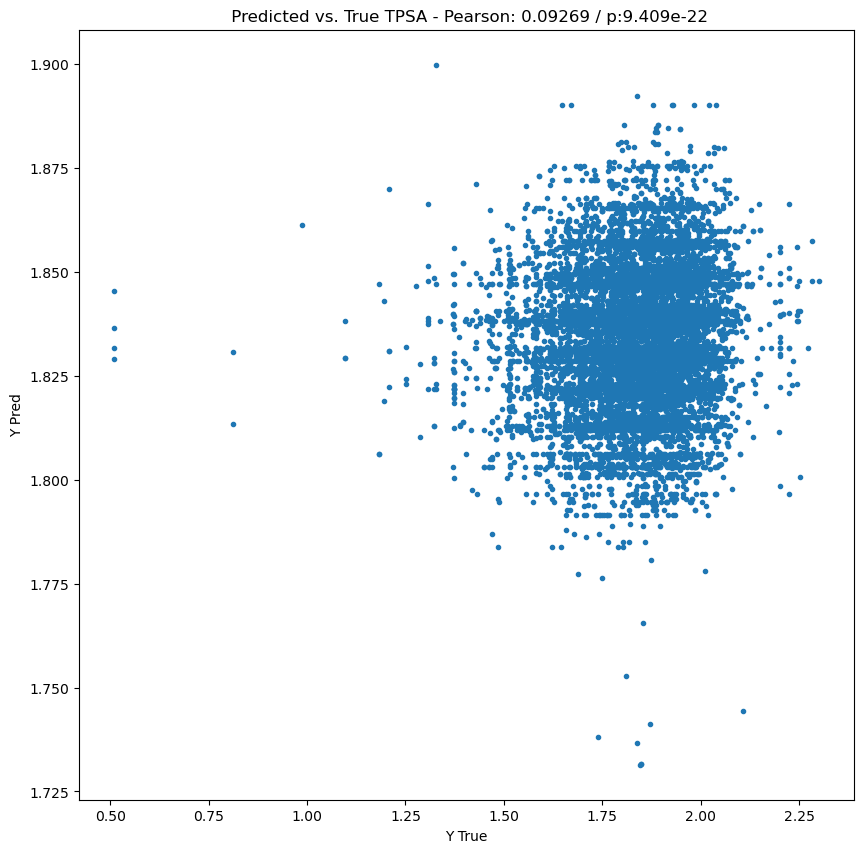

In [46]:
fig = plt.figure(figsize=(10,10))
plt.plot(y_test_np, y_pred, '.')
plt.title(f" Predicted vs. True TPSA - Pearson: {pearson_corr:.5f} / p:{pearson_p:.3e}")
plt.xlabel("Y True");
plt.ylabel("Y Pred");
# plt.xlim(1.775, 1.875)
# plt.xlim(1.775, 1.875)

Text(0.5, 0, 'TPSA Value')

Text(0, 0.5, 'Compounds')

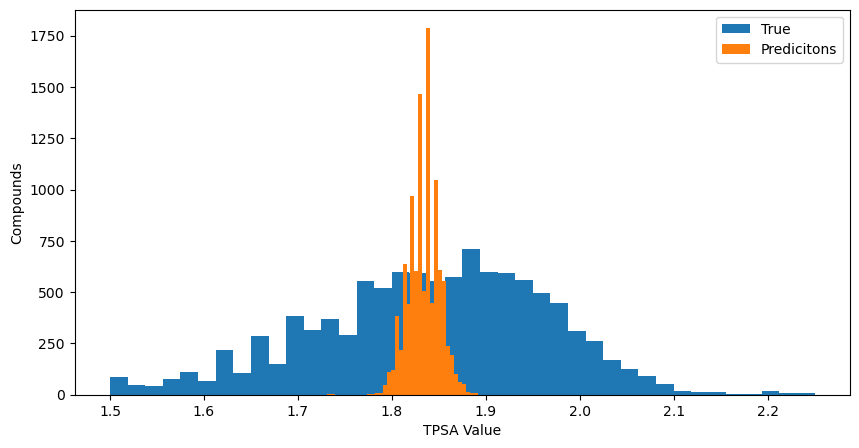

In [47]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
num_bins = 40
# fig, ax = plt.subplots()
 
# the histogram of the data

fig = plt.figure(figsize=(10,5))
n, bins, patches = plt.hist(y_test_np, num_bins, density=False, label = 'True', range=[1.5,2.25] )
# We can set the number of bins with the *bins* keyword argument.
n, bins, patches = plt.hist(y_pred, num_bins, density=False, label='Predicitons' )
plt.xlabel('TPSA Value')
plt.ylabel('Compounds')
plt.legend()
# ax.set_title('Histogram of normal distribution sample: '
#              fr'$\mu={mu:.0f}$, $\sigma={sigma:.0f}$')
# axs[1].hist(dist2, bins=n_bins)

# XGBoost - Training using XGBoost native interface

### Plot importance 

In [ ]:
# train_score = xgb_reg.score(train_X, train_y)
# val_score = xgb_reg.score(val_X, val_y)
# test_score = xgb_reg.score(test_X, test_y)

In [ ]:
print(f" R2 score - Training   : {train_score:0.6f}")
print(f" R2 score - Validation : {val_score:0.6f}")
print(f" R2 score - Test data  : {test_score:0.6f}")

[Text(0, 0, 'f126'),
 Text(0, 1, 'f377'),
 Text(0, 2, 'f748'),
 Text(0, 3, 'f775'),
 Text(0, 4, 'f777'),
 Text(0, 5, 'f778'),
 Text(0, 6, 'f789'),
 Text(0, 7, 'f808'),
 Text(0, 8, 'f811'),
 Text(0, 9, 'f813'),
 Text(0, 10, 'f855'),
 Text(0, 11, 'f908'),
 Text(0, 12, 'f1012'),
 Text(0, 13, 'f1380'),
 Text(0, 14, 'f247')]

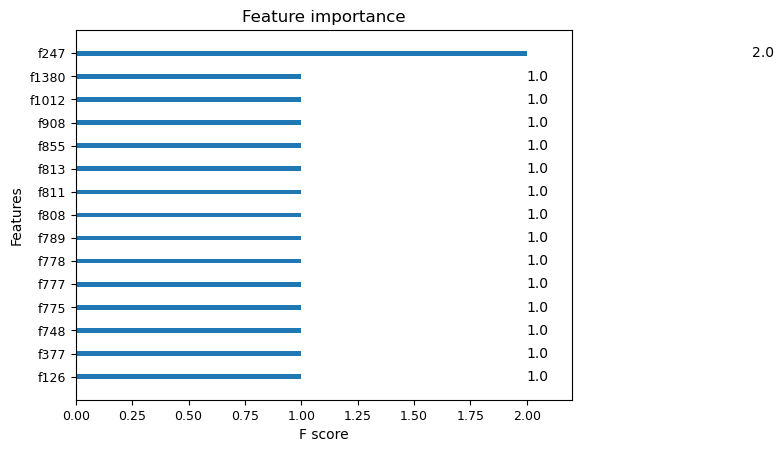

In [48]:
# fig = plt.figure(figsize=(20, 20))
# plt.yticks(fontsize = 12)
# ax = fig.add_subplot()
# ax.set_xlim(10,50)
ax = xgb.plot_importance(model_copy, max_num_features= None,  grid = False,  show_values = True, )
for label in ( ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(9)
ax.get_yticklabels()
# ax.autoscale(enable=None, axis="y", tight=True)

<Axes: >

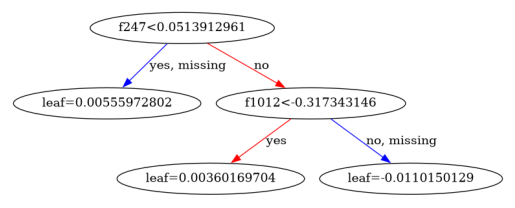

In [29]:
from graphviz import Source 
xgb.plot_tree(model_copy,num_tress=5)

In [30]:
# model_copy.attributes()
model_copy.feature_names
model_copy.

TypeError: Booster.get_split_value_histogram() missing 1 required positional argument: 'feature'

In [29]:
xgb.get_config()

{'use_rmm': False, 'verbosity': 1}